In [27]:
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END, MessageGraph
from langgraph.graph.message import add_messages
from langgraph.types import Command

class RaTsql(MessageGraph):
    some_keys : list

class State(TypedDict):
    simlar_quries: Annotated[list, add_messages]
    pruned_schema: Annotated[list, add_messages]

class FeedbackState(State):
    simlar_quries: Annotated[list, add_messages]
    pruned_schema: Annotated[list, add_messages]



# 1. Head

In [7]:
head = StateGraph(State)

#### Nodes

In [8]:
def user_querstion(state: State) -> Command[Literal["rag_node"]]:
    return Command(
        goto="__end__"
    )
def rag_node(state: State) -> Command[Literal["method_router_node"]]:
    return Command(
        goto="apporach_router"
    )


def method_router_node(state: State) -> Command[Literal["get_pruned_schema_from_rag", "get_pruned_schema_from_full_approach"]]:
    return Command(
        goto="get_pruned_schema_from_rag"
    )

# def get_pruned_schema_from_rag(state: State) -> Command[Literal["gen_sql1", "dense_schema"]]:
def get_pruned_schema_from_rag(state: State) -> Command[Literal["__end__"]]:
    return Command(
        goto="gen_sql1"
    )

# def get_pruned_schema_from_full_approach(state: State) -> Command[Literal["gen_sql1", "dense_schema"]]:
def get_pruned_schema_from_full_approach(state: State) -> Command[Literal["__end__"]]:
    return Command(
        goto="gen_sql1"
    )

### Edges

In [9]:
head.add_node("user_querstion", user_querstion)
head.add_node("rag_node", rag_node)
head.add_node("method_router_node", method_router_node)
head.add_node("get_pruned_schema_from_rag", get_pruned_schema_from_rag)
head.add_node("get_pruned_schema_from_full_approach", get_pruned_schema_from_full_approach)


### Graph

In [10]:
head.add_edge(START, "user_querstion")
head_graph = head.compile()

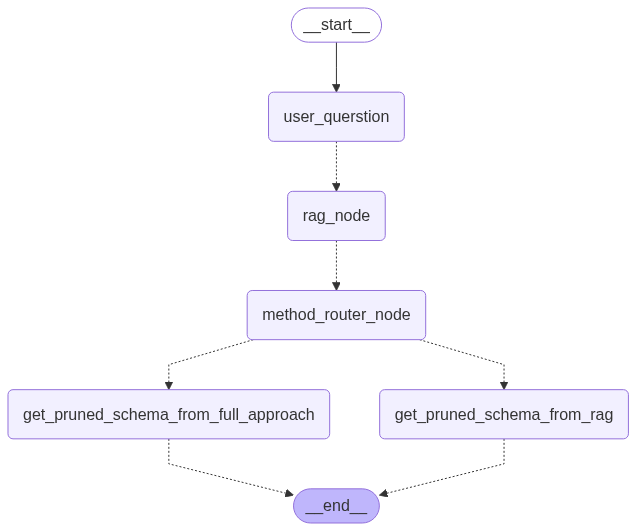

In [11]:
head_graph

# 2. Body

In [19]:
body = StateGraph(State)

#### Nodes

In [14]:

def gen_sql1(state: State) -> Command[Literal["get_schema_from_sql", "gen_sql3"]]:
    return Command(
        goto="dense_schema"
    )

def get_schema_from_sql(state: State) -> Command[Literal["dense_schema"]]:
    return Command(
        goto="dense_schema"
    )

def dense_schema(state: State) -> Command[Literal["gen_hints"]]:
    return Command(
        goto="gen_hints"
    )

def gen_hints(state: State) -> Command[Literal["gen_sql2"]]:
    return Command(
        goto="gen_sql2"
    )

def gen_sql2(state: State) -> Command[Literal["gen_sql3"]]:
    return Command(
        goto="gen_sql3"
    )

def gen_sql3(state: State) -> Command[Literal["loop_sql"]]:
    return Command(
        goto="loop_sql"
    )

def loop_sql(state: State) -> Command[Literal["final_answer"]]:
    return Command(
        goto="__end__"
    )

def final_answer(state: State) -> Command[Literal["__end__"]]:
    return Command(
        goto="__end__"
    )


### Edges

In [15]:
body.add_node("get_schema_from_sql", get_schema_from_sql)
body.add_node("gen_sql1", gen_sql1)
body.add_node("dense_schema", dense_schema)
body.add_node("gen_hints", gen_hints)
body.add_node("gen_sql2", gen_sql2)
body.add_node("gen_sql3", gen_sql3)
body.add_node("loop_sql", loop_sql)
body.add_node("final_answer", final_answer)

In [16]:
body.add_edge(START, "gen_sql1")
body_graph = body.compile()

### Graph

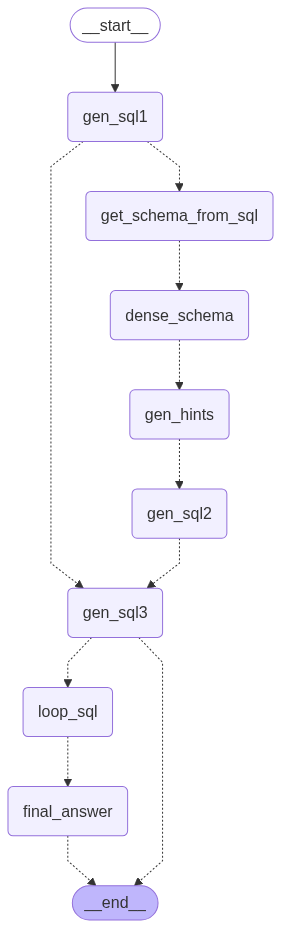

In [17]:
body_graph

# 2. Tail

In [23]:
tail = StateGraph(FeedbackState)

#### Nodes

In [22]:
def feedback_router(state: State) -> Command[Literal["feedback_node", "__end__"]]:
    return Command(
        goto="__end__"
    )

def feedback_node(state: State) -> Command[Literal["positive", "negative"]]:
    return Command(
        goto="__end__"
    )
def positive(state: State) -> Command[Literal["verify_feedback"]]:
    return Command(
        goto="__end__"
    )
def negative(state: State) -> Command[Literal["send_to_dev_to_tune_approach"]]:
    return Command(
        goto="__end__"
    )

def verify_feedback(state: State) -> Command[Literal["store_in_rag"]]:
    return Command(
        goto="__end__"
    )
def send_to_dev_to_tune_approach(state: State) -> Command[Literal["__end__"]]:
    return Command(
        goto="__end__"
    )
def store_in_rag(state: State) -> Command[Literal["__end__"]]:
    return Command(
        goto="__end__"
    )

### Edges

In [24]:
tail.add_node("feedback_router", feedback_router)
tail.add_node("feedback_node", feedback_node)
tail.add_node("positive", positive)
tail.add_node("negative", negative)
tail.add_node("verify_feedback", verify_feedback)
tail.add_node("send_to_dev_to_tune_approach", send_to_dev_to_tune_approach)
tail.add_node("store_in_rag", store_in_rag)


### Graph

In [25]:
tail.add_edge(START, "feedback_router")
tail_graph = tail.compile()

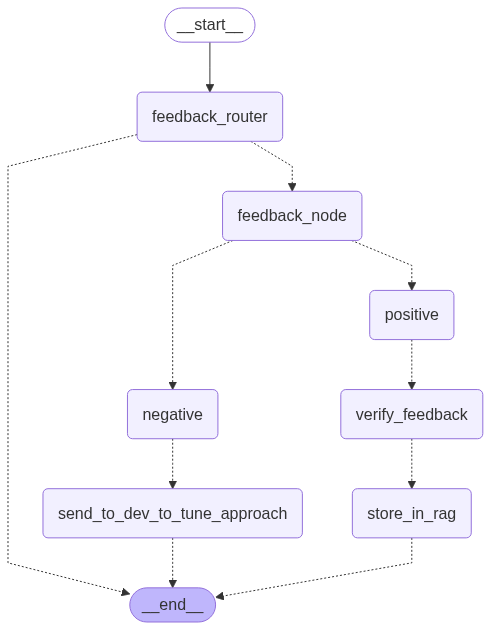

In [26]:
tail_graph

# RaTsql

In [28]:
ratsql_builder = StateGraph(RaTsql)

In [29]:
def head(state: RaTsql) -> Command[Literal["body"]]:
    return Command(
        goto="body"
    )

def body(state: RaTsql) -> Command[Literal["tail"]]:
    return Command(
        goto="tail"
    )

def tail(state: RaTsql) -> Command[Literal["__end__"]]:
    return Command(
        goto="__end__"
    )

In [30]:
ratsql_builder.add_node("head", head)
ratsql_builder.add_node("body", body)
ratsql_builder.add_node("tail", tail)

ratsql_builder.add_edge(START, "head")

RaTsql = ratsql_builder.compile()

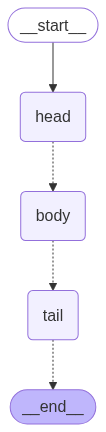

In [31]:
RaTsql